In [98]:
import pandas as pd
import networkx as nx
from math import exp
import matplotlib.pyplot as plt
import numpy as np
from itertools import count

In [99]:
from jupyterthemes import jtplot
%matplotlib inline
jtplot.reset()

C:\Users\juann\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\juann\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\juann\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [100]:
nodes = pd.read_csv('routes.csv', header=None, names=['i', 'j'])
g = nx.from_pandas_edgelist(nodes, 'i', 'j',create_using=nx.DiGraph())
print('Number of nodes', g.number_of_nodes())
print('Number of edges', g.number_of_edges())

Number of nodes 151
Number of edges 3622


In [101]:
# We have a dataframe of countries (nodes)
countries = pd.read_csv('data.csv')
countries.set_index('country', inplace=True)
countries['population'] = 1000000*countries['population']
# Travellers are for an entire year, but our timeline is weekly
countries['travellers'] = countries['travellers']/52

countries.head()

,population,travellers,hdi
country,,,
Afghanistan,32760000.0,37113.596154,0.498
Albania,2900000.0,79730.769231,0.773
Algeria,39100000.0,54596.153846,0.747
Angola,26920000.0,23932.519231,0.581
Antigua and Barbuda,98000.0,19996.326923,0.780


In [108]:
# For each country, we need the travellers going from the neighboring countries
def return_list_neighbors(i, g):
    return [in_neighb for (in_neighb,j) in g.in_edges(i)]
print('Albania\'s neighbors :', return_list_neighbors('Albania', g))

# For all countries
def compute_sum_travelers_neighboring_countries(g):
    sum_travel_neighbors = []
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum_n = 0
        for n in neighbors:
            sum_n += countries.loc[n]['travellers']
        sum_travel_neighbors.append(sum_n)
    return sum_travel_neighbors
countries['sum_travel_neighbors'] = compute_sum_travelers_neighboring_countries(g)

countries.head()

Albania's neighbors : ['Austria', 'Germany', 'Greece', 'Italy', 'Slovenia', 'Turkey', 'United Kingdom']


,population,travellers,hdi,sum_travel_neighbors
country,,,,
Afghanistan,32760000.0,37113.596154,0.498,2.738878e+06
Albania,2900000.0,79730.769231,0.773,3.826346e+06
Algeria,39100000.0,54596.153846,0.747,1.192336e+07
Angola,26920000.0,23932.519231,0.581,9.607654e+06
Antigua and Barbuda,98000.0,19996.326923,0.780,4.422177e+06


In [106]:
# W_ij the weight between country i and j represents the number of travellers between i and j
def compute_edge_weight(i, j):
    return countries.loc[i]['travellers']*countries.loc[j]['travellers']/(countries.loc[i]['sum_travel_neighbors'])
        
def add_edge_weights():
    for e in g.edges():
        g[e[0]][e[1]]['weight'] = compute_edge_weight(e[0], e[1])

add_edge_weights()
print('France - Singapore :', g['France']['Singapore'])
print('Singapore - France :', g['Singapore']['France'])

France - Singapore : {'weight': 267.3294236045875}
Singapore - France : {'weight': 12656.470084309465}


In [200]:
# Initialisation for our model :
r0 = 5
alpha = 0.15
beta = 0.4
period = 52
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1

In [225]:
# Creation of new data frames
pop_tot = pd.DataFrame(index = countries.index)
incubating = pd.DataFrame(index = countries.index)
sick = pd.DataFrame(index = countries.index)
infected = pd.DataFrame(index = countries.index)
recovered = pd.DataFrame(index = countries.index)
susceptible = pd.DataFrame(index = countries.index)
deceased = pd.DataFrame(index = countries.index)
ri = pd.DataFrame(index = countries.index)

# # Initialisation for t=0 :
pop_tot['t=0'] = countries['population']
incubating['t=0'] = np.zeros(countries.shape[0])
sick['t=0'] = np.zeros(countries.shape[0])
infected['t=0'] = np.zeros(countries.shape[0])
recovered['t=0'] = np.zeros(countries.shape[0])
susceptible['t=0'] = countries['population']
deceased['t=0'] = np.zeros(countries.shape[0])
ri['t=0'] = np.zeros(countries.shape[0])


# We infect the starting country with a certain number of people
infected.loc[country_start]['t=0'] = nb_infected_start
incubating.loc[country_start]['t=0'] = nb_infected_start
susceptible.loc[country_start]['t=0'] = pop_tot.loc[country_start]['t=0'] - incubating.loc[country_start]['t=0']

### Computing the reproduction number $R_i$ (average number of people that an incubated person will infect in a week) 
It should :

- Be inversly proportionate to the HDI (with an impact corresponding to beta). We used a linearly decreasing function such that : for a maximal HDI, it should be equal to minus beta time $r_0$, for a minimal HDI, it should be equal to plus beta time $r_0$. Solving these two conditions, we obtain the following affine function's parameters $\large a=-2*\beta*\frac{r_0}{max-min}$ and $\large b=\beta*r_0 - a*min$ where max and min respectively represent the maximum and minimum of the HDI. 
Thus, the HDI's function is $\large f(HDI)=r_0 +a*HDI + b$.

- Decrease with time, since awareness increases, the illness mutates and the immune system adjusts. We used the shape of the sigmoid function to build a function with values between 1 and 0, decreasing slowly at the beginning and at the end, with a higher slope around the middle of the period, here 26 weeks, depending on the alpha parameter. We obtain $\large time(t)=1-\frac{1}{1+e^{(-\alpha * (t-26))}}$. See plot below. 

Finally, we have $R_i(t)=f(HDI)*time(t)$.

In [202]:
print('min HDI: ',countries.hdi.min())
print('max HDI: ',countries.hdi.max())
print('max HDI: ',countries.hdi.median())


min HDI:  0.354
max HDI:  0.946
max HDI:  0.747


Country 	 HDI 	 RI
Afghanistan : 	 0.498 	 6.027027027027026
France : 	 0.894 	 3.35135135135135


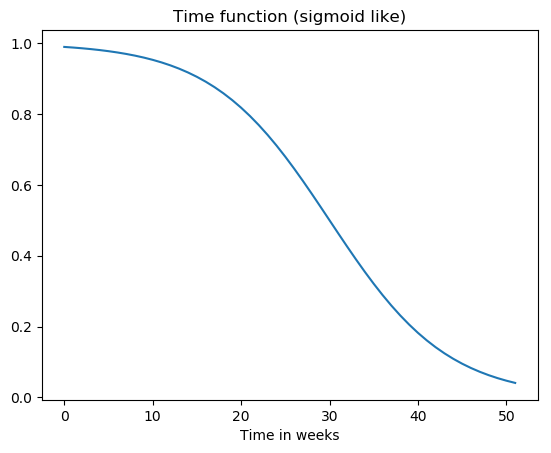

In [312]:
# Contamination decreases with time

def time(t):
    # translation to the right
    x=t-30
    # oposite sigmoid + 1
    f=1 -(1/(1+exp(-alpha*x)))
    return f

# Plotting our time function
exp_test=[time(t) for t in range(52)]
plt.title("Time function (sigmoid like)")
plt.xlabel("Time in weeks")
plt.plot(exp_test)

# We calculate the average number infected by an incubated person in a week
# The higher the HDI of a country, the less people will be infected
def reproduction_number_by_country(t):
    minim=countries.hdi.min()
    maxim=countries.hdi.max()
    # Affine function of HDI :
    a=-2*beta*r0/(maxim-minim)
    b=beta*r0-a*minim
    if t==0:
        return (r0 +a*countries['hdi'] + b)
    else:
        # We calculate the percentage of people that can still be infected
        to_be_infected = susceptible.iloc[:,t] / pop_tot.iloc[:,t]
        result = ri.iloc[:,t-1] * to_be_infected
        return result*time(t)

# Let us initialize the ri for t=0
ri['t=0'] = reproduction_number_by_country(0)

print('Country \t HDI \t RI')
print('Afghanistan : \t', countries.loc['Afghanistan']['hdi'], '\t',ri.loc['Afghanistan', 't=0'])
print('France : \t', countries.loc['France']['hdi'], '\t',ri.loc['France', 't=0'])

### Plotting the distibution for the different $R_i$ at $t=0$

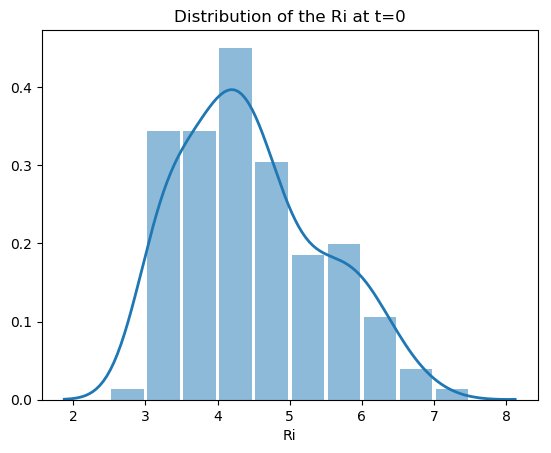

In [258]:
import seaborn as sns

plt.figure()
sns.distplot(ri['t=0'], kde_kws={"lw": 2}, bins = np.arange(2,8,0.5), hist_kws={"linewidth": 3, "rwidth": 0.9, "alpha": 0.5})
plt.title('Distribution of the Ri at t=0')
plt.xlabel('Ri')
plt.show()

In [240]:
# Incubated people coming to the country at time t
def number_incubated_coming(t):
    incubated_coming = pd.DataFrame(index = countries.index)
    incubated_coming['nb_coming']=np.zeros(countries.shape[0])
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for j in neighbors:
            sum += g[j][i]['weight']*incubating.loc[j]['t='+str(t-1)]/(pop_tot.loc[j]['t='+str(t-1)] - sick.loc[j]['t='+str(t-1)])
        incubated_coming.loc[i,'nb_coming'] = round(sum)
        
    return incubated_coming

In [297]:
# Function to actualize (add column corresponding to t) each dataframe t>0 :

def infection_actualization(t, country_start) :
    if t>0 :
        index='t='+str(t)
        # actualizing deceased, recovered, pop_tot and susceptible => variables of "beginning of period":
        deceased[index]=mortality_rate*sick.iloc[:,t-1]
        recovered[index]=sick.iloc[:,t-1]-deceased[index]
        pop_tot[index]=pop_tot.iloc[:,t-1]-deceased[index]
        susceptible[index]=susceptible.iloc[:,t-1]-incubating.iloc[:,t-1]

        # actualizing ri :
        ri[index] = reproduction_number_by_country(t)

        # actualizing incubating, sick & infected => variables depending on the newly infected people:

        # sick people at time t are the incubated of t-1 who stayed in the country
        sick[index]=incubating.iloc[:,t-1]*(1-(countries.travellers/(pop_tot.iloc[:,t-1]-sick.iloc[:,t-1])))
        
        incubating[index]=sick[index]*ri.iloc[:,t-1]+number_incubated_coming(t).iloc[:,0]*(ri.iloc[:,t-1])

        infected[index]=sick[index]+number_incubated_coming(t).iloc[:,0]+incubating[index]

In [313]:
# Initialisation for our model :
r0 = 5
alpha = 0.15
beta = 0.4
period = 30
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1

In [314]:
# Creation of new data frames
pop_tot = pd.DataFrame(index = countries.index)
incubating = pd.DataFrame(index = countries.index)
sick = pd.DataFrame(index = countries.index)
infected = pd.DataFrame(index = countries.index)
recovered = pd.DataFrame(index = countries.index)
susceptible = pd.DataFrame(index = countries.index)
deceased = pd.DataFrame(index = countries.index)

# # Initialisation for t=0 :
pop_tot['t=0'] = countries['population']
incubating['t=0'] = np.zeros(countries.shape[0])
sick['t=0'] = np.zeros(countries.shape[0])
infected['t=0'] = np.zeros(countries.shape[0])
recovered['t=0'] = np.zeros(countries.shape[0])
susceptible['t=0'] = countries['population']
deceased['t=0'] = np.zeros(countries.shape[0])


# We infect the starting country with a certain number of people
infected.loc[country_start]['t=0'] = nb_infected_start
incubating.loc[country_start]['t=0'] = nb_infected_start
susceptible.loc[country_start]['t=0'] = pop_tot.loc[country_start]['t=0'] - incubating.loc[country_start]['t=0']

In [315]:
# Create the values for the dataframes, for all periods

def data_creation(period, country_start):
    for i in range(1,period+1):
        infection_actualization(i,country_start = country_start)
        print("Number of periods processed:", i)

In [316]:
data_creation(period, country_start)

Number of periods processed: 1
Number of periods processed: 2
Number of periods processed: 3
Number of periods processed: 4
Number of periods processed: 5
Number of periods processed: 6
Number of periods processed: 7
Number of periods processed: 8
Number of periods processed: 9
Number of periods processed: 10
Number of periods processed: 11
Number of periods processed: 12
Number of periods processed: 13
Number of periods processed: 14
Number of periods processed: 15
Number of periods processed: 16
Number of periods processed: 17
Number of periods processed: 18
Number of periods processed: 19
Number of periods processed: 20
Number of periods processed: 21
Number of periods processed: 22
Number of periods processed: 23
Number of periods processed: 24
Number of periods processed: 25
Number of periods processed: 26
Number of periods processed: 27
Number of periods processed: 28
Number of periods processed: 29
Number of periods processed: 30


In [326]:
infected.loc["United States"].sum()/countries.loc['United States','population']

0.005731522913861933

In [327]:
infected.loc["China"].sum()/countries.loc['China','population']

0.06341341946340164

## Creation of the DataFrame that will indicate the status of each country, through time
* **Epidemic threshold**: We set it at 200 for 100,000 inhabitants.

The cycle that a country can go trhough is the following:
Susceptible => Exposed => Epidemic => Recovered

* *Susceptible:* all countries start as susceptible.
* *Exposed*: if one person is infected in the country, it is considered exposed.
* *Epidemic:* if the number of infected surpasses the epidemic threshold.
* *Recovered*: if the country was infected, but goes back under the epidemic threshold.

In [413]:
zeros = np.zeros(shape=infected.shape)
country_status=pd.DataFrame(zeros, index = infected.index, columns = infected.columns)
epidemic_threshold=200/100000

# Initialization at t=0, all countries are susceptible except the exposed country
country_status.replace(to_replace= 0, value = 'Susceptible',inplace=True)
country_status.loc[country_start,'t=0']='Exposed'

# Replacing the Epidemic and the Exposed:
for index, row in infected.iterrows():
    for col in infected :
        if infected.loc[index, col] / pop_tot.loc[index, col] > epidemic_threshold:
            country_status.loc[index, col] = 'Epidemic'
        elif infected.loc[index, col] >= 1:
            country_status.loc[index, col] = 'Exposed'

# Replacing the Recovered:
for index, row in country_status.iterrows():
    i=0
    for col in country_status :
        if (country_status.loc[index, col] == 'Exposed' or country_status.loc[index, col] =='Susceptible') and i>0:
            if country_status.loc[index,'t='+str(i-1)] == 'Epidemic' or country_status.loc[index,'t='+str(i-1)] =='Recovered' :
                country_status.loc[index, col]='Recovered'
        i+=1

In [421]:
country_status.sample(n=5)

,t=0,t=1,t=2,t=3,t=4,t=5,t=6,t=7,t=8,t=9,...,t=21,t=22,t=23,t=24,t=25,t=26,t=27,t=28,t=29,t=30
country,,,,,,,,,,,,,,,,,,,,,
Singapore,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,...,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered
Sweden,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,Exposed,...,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered
Colombia,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,...,Epidemic,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered
Greece,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,...,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered
Hong Kong,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,Exposed,Exposed,...,Epidemic,Epidemic,Epidemic,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered,Recovered


# Building the Graph

In [74]:
# Incubated people staying in the country at time t
def number_incubated_staying(t):
    incubated_staying = {}
    for i in countries.index:
        incubated_staying[i] = countries.loc[i]['incubation'+str(t-1)]*(1 - 
                    countries.loc[i]['travellers']/(countries.loc[i]['population'] - 
                    countries.loc[i]['dead'+str(t-1)] - countries.loc[i]['sick'+str(t-1)]))
    return incubated_staying
# Incubated people coming to the country at time t
def number_incubated_coming(t):
    incubated_coming = {}
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for j in neighbors:
            sum += g[j][i]['weight']*countries.loc[j]['incubation'+str(t-1)]/(countries.loc[j]['population'] - 
                                countries.loc[j]['dead'+str(t-1)] - countries.loc[j]['sick'+str(t-1)])
        incubated_coming[i] = sum
    return incubated_coming

incubated_coming = number_incubated_coming(1)
print('Number of incubated staying in France :', number_incubated_staying(1)['France'])
print('Number of incubated coming to France :', incubated_coming['France'])
print('Number of incubated coming to Germany :', incubated_coming['Germany'])
print('Number of incubated coming to the UK :', incubated_coming['United Kingdom'])

sum = 0
for n in return_list_neighbors('France', g):
    sum += incubated_coming[n]
print('For all of France\' neighbors :', sum)

KeyError: 'Afghanistan'

In [75]:
def infection_impact(t):
    ri = reproduction_number_by_country(t)
    incubated_staying = number_incubated_staying(t)
    incubated_coming = number_incubated_coming(t)
    
    countries['dead'+str(t)] = mortality_rate*countries['sick'+str(t-1)]
    
    infected = []
    for i in countries.index:
        tmp = (incubated_staying[i] + incubated_coming[i])*(1 + ri[i])
        if tmp <= countries.loc[i]['population']:
            infected.append(tmp)
        else:
            infected.append(countries.loc[i]['population'])
    countries['infected'+str(t)] = infected
    '''countries['infected'+str(t)] = [(incubated_staying[i] 
                + incubated_coming[i])*(1 + ri[i]) if ((incubated_staying[i] 
                + incubated_coming[i])*(1 + ri[i]) <= countries.loc[i]['population']) for i in countries.index]'''
    
    countries['healthy'+str(t)] = [countries.loc[i]['population'] - countries.loc[i]['infected'+str(t)] for i in countries.index]
    countries['sick'+str(t)] = countries['incubation'+str(t - 1)] 
    countries['incubation'+str(t)] = countries['infected'+str(t)] - countries['sick'+str(t)]

print('Country : \t Infected \t Dead')
for p in range(1, period):
    infection_impact(p)
    print(p)
    print('France : \t', round(countries.loc['France']['infected'+str(p)], 3), '\t',
                      round(countries.loc['France']['dead'+str(p)], 3))
    print('Germany : \t', round(countries.loc['Germany']['infected'+str(p)], 3), '\t',
                       round(countries.loc['Germany']['dead'+str(p)], 3))
    print('UK : \t \t', round(countries.loc['United Kingdom']['infected'+str(p)], 3), '\t',
                  round(countries.loc['United Kingdom']['dead'+str(p)], 3))
    print('Afghanistan : \t', round(countries.loc['Afghanistan']['infected'+str(p)], 3), '\t',
                           round(countries.loc['Afghanistan']['dead'+str(p)], 3))

Country : 	 Infected 	 Dead


KeyError: 'Afghanistan'

In [52]:
for p in range(period+1):
    nx.set_node_attributes(g, countries['infected'+str(p)].to_dict(), 'infected'+str(p))
nx.get_node_attributes(g, 'infected5')

{'Afghanistan': 1.9699431134236336,
 'Azerbaijan': 27.379220690021295,
 'India': 105.0286373737525,
 'Iran': 78.84421464315055,
 'Kuwait': 0.9446383046868136,
 'Tajikistan': 0.006697447147391298,
 'Turkey': 25.363304386356386,
 'United Arab Emirates': 139.55313263453488,
 'Albania': 0.5087592223614302,
 'Austria': 29.74257759953861,
 'Germany': 181.1042885147547,
 'Greece': 23.735334372385257,
 'Italy': 76.36903118301309,
 'Slovenia': 18.328985830794924,
 'United Kingdom': 132.58087380505927,
 'Algeria': 17.967468861184237,
 'Belgium': 32.88619289052178,
 'Burkina Faso': 9.254931391830056,
 'Canada': 90.48717751041171,
 'China': 464.1072233135993,
 "Cote d'Ivoire": 23.04705268407456,
 'Egypt': 55.28804233830122,
 'France': 20282.016886901445,
 'Jordan': 4.34409103106262,
 'Lebanon': 8.410619100933754,
 'Libya': 0.2884778213808937,
 'Malta': 0.9825166402351122,
 'Morocco': 28.5954797925655,
 'Niger': 0.11858375862138495,
 'Portugal': 4.502563514044857,
 'Russia': 137.03979952166563,
 'S

In [53]:
# get unique groups
groups = set(nx.get_node_attributes(g,'infected5').values())
mapping = dict(zip(sorted(groups),count()))
nodes = g.nodes()
colors = [mapping[g.node[n]['infected5']] for n in nodes]]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

SyntaxError: invalid syntax (<ipython-input-53-1229e4fbec83>, line 5)